In [1]:
 from julia import Julia
jl = Julia(sysimage = "/home/callum/ASF/Fitting/sys_model.so")

In [2]:
jl.eval('push!(LOAD_PATH, "/home/callum/ASF/Fitting/TAU_Hetro_FIT.jl")')

/home/callum/.local/lib/python3.10/site-packages/julia/core.py:709: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(


['/home/callum/ASF/', '/home/callum/ASF/Fitting/TAU_Hetro_FIT.jl']

In [ ]:
jl.include('/home/callum/ASF/Fitting/TAU_HOMO_FIT.jl')
jl.include('/home/callum/ASF/Fitting/ODE_FIT.jl')

In [13]:
jl.include('/home/callum/ASF/Fitting/TAU_HETRO_FIT.jl')

<PyCall.jlwrap Main.SIR_TAU_M>

In [5]:
import matplotlib.pyplot as plt

In [5]:
import os
import tempfile
import numpy as np
import scipy as sp


from pyabc import ABCSMC, RV, Distribution, LocalTransition, MedianEpsilon
from pyabc.visualization import plot_data_callback, plot_kde_2d
import pyabc
#db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")

In [14]:
model1 = jl.SIR_TAU_M.model_1
model2 = jl.SIR_TAU_M.model_2
model3 = jl.SIR_TAU_M.model_3
model4 = jl.SIR_TAU_M.model_4

In [23]:
models  =[model1,model2,model3,model4]

In [15]:
distance = jl.SIR_TAU_M.distance
obs = jl.SIR_TAU_M.observation

In [16]:
obs

{'SS': array([  1.5,  75. , 180. ])}

In [24]:
parameter_prior = Distribution(p1=RV("uniform", 0.0, 1.0),p2=RV("uniform", 0.0, 0.1),p3=RV("uniform", 0.0, 1.0))
parameter_prior.get_parameter_names()
params = [parameter_prior,parameter_prior,parameter_prior,parameter_prior, parameter_prior,parameter_prior,parameter_prior,parameter_prior]
params = [parameter_prior,parameter_prior,parameter_prior,parameter_prior]

gt_par = {"p1": 0.4,"p2": 0.05,"p3": 0.5}

In [22]:
distance(model1(gt_par),obs)
distance(model2(gt_par),obs)
distance(model3(gt_par),obs)
distance(model4(gt_par),obs)

2.694456671065735

In [26]:
from pyabc import ABCSMC, RV, Distribution, MulticoreEvalParallelSampler

In [15]:
abc = ABCSMC(
    model1,
    parameter_prior,
    distance,
    sampler=MulticoreEvalParallelSampler(n_procs=1),
)
db = tempfile.mkstemp(suffix=".db")[1]
abc.new("sqlite:///" + db, obs)
h1 = abc.run(max_nr_populations=10)

ABC.Sampler INFO: Parallelize sampling on 1 processes.
ABC.History INFO: Start <ABCSMC id=1, start_time=2023-03-03 17:09:49>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.45874069e+05.
ABC INFO: Accepted: 100 / 181 = 5.5249e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 9.28532084e+04.
ABC INFO: Accepted: 100 / 211 = 4.7393e-01, ESS: 9.6922e+01.
ABC INFO: t: 2, eps: 4.48972172e+04.
ABC INFO: Accepted: 100 / 204 = 4.9020e-01, ESS: 9.5911e+01.
ABC INFO: t: 3, eps: 2.06387219e+04.
ABC INFO: Accepted: 100 / 198 = 5.0505e-01, ESS: 9.4076e+01.
ABC INFO: t: 4, eps: 1.07447049e+04.
ABC INFO: Accepted: 100 / 207 = 4.8309e-01, ESS: 9.9580e+01.
ABC INFO: t: 5, eps: 7.15516393e+03.
ABC INFO: Accepted: 100 / 265 = 3.7736e-01, ESS: 9.6606e+01.
ABC INFO: t: 6, eps: 5.42329424e+03.
ABC INFO: Accepted: 100 / 342 = 2.9240e-01, ESS: 3.8722e+01.
ABC INFO: t: 7, eps: 4.25625551e+03.
ABC INFO: Accepted: 100 / 743 = 1.3459e-01, ESS: 8.6771e+01.
ABC INFO: t: 8, eps: 3.64309401e+03.
ABC INFO: Accepte

In [16]:
abc = ABCSMC(
    model2,
    parameter_prior,
    distance,
    sampler=MulticoreEvalParallelSampler(n_procs=1),
)
db = tempfile.mkstemp(suffix=".db")[1]
abc.new("sqlite:///" + db, obs)
h2 = abc.run(max_nr_populations=10)

ABC.Sampler INFO: Parallelize sampling on 1 processes.
ABC.History INFO: Start <ABCSMC id=1, start_time=2023-03-03 17:38:17>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.52224143e+05.
ABC INFO: Accepted: 100 / 149 = 6.7114e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 9.57563653e+04.
ABC INFO: Accepted: 100 / 206 = 4.8544e-01, ESS: 9.8462e+01.
ABC INFO: t: 2, eps: 4.24255990e+04.
ABC INFO: Accepted: 100 / 185 = 5.4054e-01, ESS: 7.8053e+01.
ABC INFO: t: 3, eps: 2.12589345e+04.
ABC INFO: Accepted: 100 / 165 = 6.0606e-01, ESS: 9.8996e+01.
ABC INFO: t: 4, eps: 1.18749141e+04.
ABC INFO: Accepted: 100 / 216 = 4.6296e-01, ESS: 9.4694e+01.
ABC INFO: t: 5, eps: 7.86319379e+03.
ABC INFO: Accepted: 100 / 245 = 4.0816e-01, ESS: 9.6306e+01.
ABC INFO: t: 6, eps: 5.68020383e+03.
ABC INFO: Accepted: 100 / 435 = 2.2989e-01, ESS: 8.4560e+01.
ABC INFO: t: 7, eps: 4.84171844e+03.
ABC INFO: Accepted: 100 / 684 = 1.4620e-01, ESS: 7.9856e+01.
ABC INFO: t: 8, eps: 4.14048505e+03.
ABC INFO: Accepte

In [17]:
abc = ABCSMC(
    model3,
    parameter_prior,
    distance,
    sampler=MulticoreEvalParallelSampler(n_procs=1),
)
db = tempfile.mkstemp(suffix=".db")[1]
abc.new("sqlite:///" + db, obs)
h3 = abc.run(max_nr_populations=10)

ABC.Sampler INFO: Parallelize sampling on 1 processes.
ABC.History INFO: Start <ABCSMC id=1, start_time=2023-03-03 18:05:33>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.39772879e+05.
ABC INFO: Accepted: 100 / 214 = 4.6729e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 8.59154063e+04.
ABC INFO: Accepted: 100 / 187 = 5.3476e-01, ESS: 9.7526e+01.
ABC INFO: t: 2, eps: 4.08081151e+04.
ABC INFO: Accepted: 100 / 222 = 4.5045e-01, ESS: 9.6858e+01.
ABC INFO: t: 3, eps: 1.65369138e+04.
ABC INFO: Accepted: 100 / 222 = 4.5045e-01, ESS: 9.7044e+01.
ABC INFO: t: 4, eps: 8.34601258e+03.
ABC INFO: Accepted: 100 / 241 = 4.1494e-01, ESS: 9.8089e+01.
ABC INFO: t: 5, eps: 5.98232138e+03.
ABC INFO: Accepted: 100 / 274 = 3.6496e-01, ESS: 8.6687e+01.
ABC INFO: t: 6, eps: 4.77382649e+03.
ABC INFO: Accepted: 100 / 612 = 1.6340e-01, ESS: 9.1755e+01.
ABC INFO: t: 7, eps: 3.98472716e+03.
ABC INFO: Accepted: 100 / 950 = 1.0526e-01, ESS: 6.1014e+01.
ABC INFO: t: 8, eps: 3.42543641e+03.
ABC INFO: Accepte

In [ ]:
db = tempfile.mkstemp(suffix=".db")[1]
abc.new("sqlite:///" + db, obs)

In [ ]:
h = abc.run(max_nr_populations=10)

In [35]:
from pyabc import ABCSMC
from pyabc.populationstrategy import AdaptivePopulationSize

abc = ABCSMC(
    models,
    params,
    distance,
    population_size=AdaptivePopulationSize(200, 0.15),
    sampler=MulticoreEvalParallelSampler(n_procs=1)
)



ABC.Sampler INFO: Parallelize sampling on 1 processes.


In [36]:
abc_id = abc.new("sqlite:////tmp/mjp.db", obs)

ABC.History INFO: Start <ABCSMC id=3, start_time=2023-03-05 16:01:27>


In [37]:
history = abc.run(minimum_epsilon=1, max_nr_populations=4)

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 3.20849561e+00.
ABC INFO: Accepted: 200 / 372 = 5.3763e-01, ESS: 2.0000e+02.
ABC.Adaptation INFO: Change nr particles 200 -> 2135
ABC INFO: t: 1, eps: 1.93564694e+00.
ABC.History INFO: Done <ABCSMC id=3, duration=8:09:02.461873, end_time=2023-03-06 00:10:30>


ProcessError: At least one worker is dead.

In [34]:
df, w = history.get_distribution(m=0,t=9)

NameError: name 'history' is not defined

In [30]:
pyabc.export(h1.db)

AttributeError: module 'pyabc' has no attribute 'export'

In [ ]:
np.concatenate(df.values)

In [ ]:
    pyabc.weighted_statistics.weighted_median(np.concatenate(df.values),w)

In [29]:
abc-export --db h1.db --out exported.csv --format csv

SyntaxError: invalid syntax (1698625841.py, line 1)

In [28]:
h2.db

'sqlite:////tmp/tmp4_dg7pt6.db'

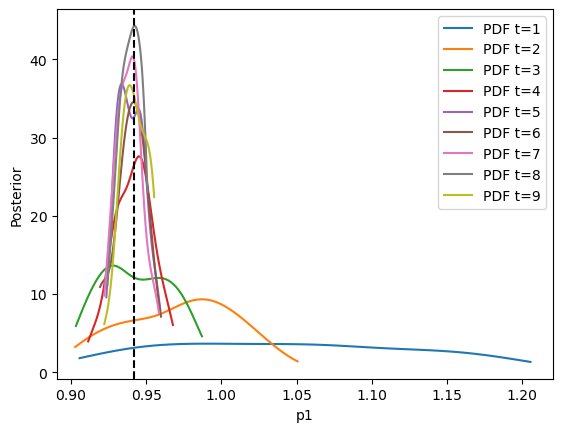

In [20]:
fig, ax = plt.subplots()
for t in range(1,h1.max_t + 1):
    df, w = h1.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df,
        w,
        x="p1",
        ax=ax,
        label=f"PDF t={t}",
    )
ax.axvline( pyabc.weighted_statistics.weighted_median(np.concatenate(df.values),w),color="k", linestyle="dashed")
ax.legend();

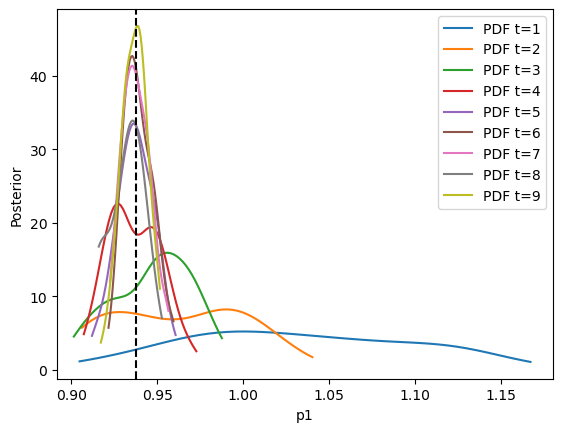

In [21]:
fig, ax = plt.subplots()
for t in range(1,h2.max_t + 1):
    df, w = h2.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df,
        w,
        x="p1",
        ax=ax,
        label=f"PDF t={t}",
    )
ax.axvline( pyabc.weighted_statistics.weighted_median(np.concatenate(df.values),w),color="k", linestyle="dashed")
ax.legend();

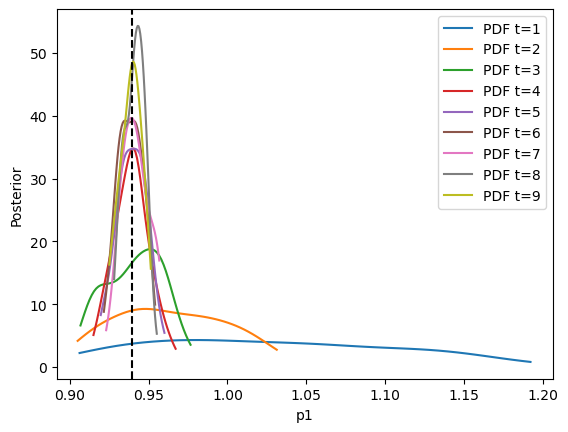

In [22]:
fig, ax = plt.subplots()
for t in range(1,h3.max_t + 1):
    df, w = h3.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df,
        w,
        x="p1",
        ax=ax,
        label=f"PDF t={t}",
    )
ax.axvline( pyabc.weighted_statistics.weighted_median(np.concatenate(df.values),w),color="k", linestyle="dashed")
ax.legend();

In [26]:
df, w = h3.get_distribution(m=0, t=9)
    
pyabc.weighted_statistics.weighted_median(np.concatenate(df.values),w)

0.9391929542842055

In [ ]:
for t in [0, 1,2,3,4,5,6,7,8,9]:
    pyabc.visualization.plot_kde_matrix_highlevel(
        h,
        t=t,
       
        
    )
    plt.gcf().suptitle(f"Posterior at t={t}")
    plt.gcf().tight_layout();

In [ ]:
abc = pyabc.ABCSMC(models, params,distance_function=distance, population_size=AdaptivePopulationSize(100, 0.15),eps=MedianEpsilon(100, median_multiplier=0.7))

In [ ]:
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")
history = abc.new(db_path, {"SS": obs})

In [ ]:
history = abc.run(minimum_epsilon=0.8, max_nr_populations=6)

In [ ]:
pyabc.visualization.plot_model_probabilities(history)

In [ ]:
pyabc.visualization.plot_model_probabilities(history)

In [ ]:
pyabc.visualization.plot_model_probabilities(history)

In [ ]:
history.get_distribution(m=0, t=t)

In [ ]:
history.get_distribution(m=0, t=0)[0]

In [ ]:
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df,
        w,
        xmin=0,
        xmax=5,
        x="mu",
        xname=r"$\mu$",
        ax=ax,
        label=f"PDF t={t}",
    )
ax.axvline(observation, color="k", linestyle="dashed")
ax.legend();

In [ ]:
for t in [0, history.max_t]:
    pyabc.visualization.plot_kde_matrix_highlevel(
        history,
        t=t,
        limits=par_limits,
        refval=gt_par,
        refval_color="grey",
    )
    plt.gcf().suptitle(f"Posterior at t={t}")
    plt.gcf().tight_layout();



In [ ]:
from pyabc.visualization import plot_kde_matrix


df, w = history.get_distribution(m=3, t= 4)
plot_kde_matrix(df, w)

In [ ]:
from pyabc.visualization import plot_kde_1d

fig, axes = plt.subplots(2)
fig.set_size_inches((6, 6))
axes = axes.flatten()
#axes[0].axvline(true_rate, color="black", linestyle="dotted")
for m, ax in enumerate(axes):
    for t in range(0, history.n_populations, 2):
        df, w = history.get_distribution(m=m, t=t)
        if len(w) > 0:  # Particles in a model might die out
            plot_kde_1d(
                df,
                w,
                "rate",
                ax=ax,
                label=f"t={t}",
                xmin=0,
                xmax=20 if m == 0 else 100,
                numx=200,
            )
    ax.set_title(f"Model {m+1}")
axes[0].legend(title="Generation", loc="upper left", bbox_to_anchor=(1, 1))

fig.tight_layout()

In [ ]:
from pyabc.populationstrategy import AdaptivePopulationSize


In [ ]:
from pyabc import ABCSMC
from pyabc.populationstrategy import AdaptivePopulationSize

abc = ABCSMC(
    [model1,model4],
    [parameter_prior,parameter_prior],
    distance_function=distance,
    population_size=AdaptivePopulationSize(500, 0.15),
    eps=MedianEpsilon(100, median_multiplier=0.7),
)

In [ ]:
abc_id = abc.new("sqlite:////tmp/mjp.db", {"SS":obs})

In [ ]:
history = abc.run(minimum_epsilon=1, max_nr_populations=5)

In [ ]:
abc.new(db_path, {"SS":obs});

In [ ]:
abc_id = abc.new("sqlite:////tmp/mjp.db", {"SS":obs})

In [ ]:
history = abc.run(minimum_epsilon=1, max_nr_populations=6)

In [ ]:
abc = ABCSMC( models=model4,
    parameter_priors=parameter_prior,
    distance_function=distance,
    population_size=200,
    transitions=LocalTransition(k_fraction=0.3),
    eps=MedianEpsilon(100, median_multiplier=0.7),
)

In [ ]:
h = abc.run(minimum_epsilon=0.1, max_nr_populations=5)

In [ ]:
for t in [0,1,2,3,4]:
    pyabc.visualization.plot_kde_matrix_highlevel(
        h,
        t=t,
    )
    plt.gcf().suptitle(f"Posterior at t={t}")
    plt.gcf().tight_layout();



In [ ]:
for t in [0,1,2,3,4]:
    pyabc.visualization.plot_kde_matrix_highlevel(
        h,
        t=t,
    )
    plt.gcf().suptitle(f"Posterior at t={t}")
    plt.gcf().tight_layout();



In [ ]:
from pyabc.visualization import plot_kde_1d

fig, axes = plt.subplots(1)
fig.set_size_inches((6, 6))
axes = axes.flatten()
axes[0].axvline(true_rate, color="black", linestyle="dotted")
for m, ax in enumerate(axes):
    for t in range(0, history.n_populations, 2):
        df, w = history.get_distribution(m=m, t=t)
        if len(w) > 0:  # Particles in a model might die out
            plot_kde_1d(
                df,
                w,
                "rate",
                ax=ax,
                label=f"t={t}",
                xmin=0,
                xmax=20 if m == 0 else 100,
                numx=200,
            )
    ax.set_title(f"Model {m+1}")
axes[0].legend(title="Generation", loc="upper left", bbox_to_anchor=(1, 1))


In [ ]:
plt.plot(aaa['t'], u[:,0])
plt.plot(aaa['t'], u[:,1])
plt.plot(aaa['t'], u[:,2])
plt.plot(aaa['t'], u[:,3])
plt.plot(aaa['t'], u[:,4])


In [ ]:
np.concatenate(aaa['u'], axis = 0 )

In [ ]:
from julia import Main

In [ ]:
aaa['u']

In [ ]:
u =  np.stack(aaa['u'])


In [ ]:
from pyabc import ABCSMC, RV, Distribution, MulticoreEvalParallelSampler

In [ ]:
abc = ABCSMC(
    model1,
    parameter_prior,
    distance,
)
db = tempfile.mkstemp(suffix=".db")[1]
abc.new("sqlite:///" + db,  {"SS":obs})
h = abc.run(max_nr_populations=5)

